In [2]:
import torch
import numpy as np
import pandas as pd
import os.path as osp
from collections import Counter

import matplotlib.pyplot as plt

from skpm import event_logs

from ppm.datasets import DatasetSchemas
from ppm.utils import parse_args, add_outcome_labels
from setup_experiment import setup_dataloaders, setup_model
from local_xai.trace_segmentation.utils import build_transition_probability_matrix

# Setup data loaders and the model

In [3]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

NUMERICAL_FEATURES = [
    "accumulated_time",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "hour_of_day",
    "min_of_hour",
    "month_of_year",
    "sec_of_min",
    "secs_within_day",
    "week_of_year",
]

In [4]:
config_path = r'D:\PycharmProjects\xAI-PPM\configs\explain_lstm_args_for_op.txt'
checkpoints_path = r'D:\PycharmProjects\xAI-PPM\persisted_models\suffix\BPI17_rnn_outcome_bpi17.pth'

args = parse_args(config_path=config_path)
config = vars(args)
config["log"] = args.dataset
config["continuous_features"]  = (NUMERICAL_FEATURES
        if (
            args.continuous_features is not None
            and "all" in args.continuous_features
        )
        else args.continuous_features
    )
config["checkpoint_path"] = checkpoints_path

In [5]:
log = getattr(event_logs, config["log"])()

labels_dict = {"O_Accepted": 0, "O_Cancelled": 1, "O_Refused": 2}
column_schema = getattr(DatasetSchemas, config["log"])()
labeled_df = add_outcome_labels(log.dataframe, column_schema, labels_dict)

# Remove O_Refused to convert the task to a binary classification
binary_labeled_df = labeled_df[labeled_df["outcome"] != 2]
train_loader, test_loader = setup_dataloaders(config, binary_labeled_df, log.unbiased_split_params)
model = setup_model(config, train_loader.dataset.log, model_name='outcome_predictor')

 [*] Loading checkpoint from D:\PycharmProjects\xAI-PPM\persisted_models\suffix\BPI17_rnn_outcome_bpi17.pth succeed!


# Extract cases for generating explanations

In [6]:
# a) Extracting sequences that predicted to have "O_Cancelled" as an outcome of the given trace

pred_cases_info  =  {'tp': {'ids': [],  'cases': [], 'y_pred': [], 'y_true': []},
                     'tn': {'ids': [],  'cases': [], 'y_pred': [], 'y_true': []},
                     'fp': {'ids': [],  'cases': [], 'y_pred': [], 'y_true': []},
                     'fn': {'ids': [],  'cases': [], 'y_pred': [], 'y_true': []}
                     }

prefix_len = 15
dataset_device = config['device']

for ind, batch in enumerate(test_loader):
    x_cat, x_num, y_cat, _ = batch # type: ignore
    x_cat, x_num, y_cat = x_cat[:, :prefix_len, :], x_num[:, :prefix_len, :], y_cat[:, :prefix_len]
    x_cat, x_num = (x_cat.to(dataset_device), x_num.to(dataset_device))

    attention_mask = (x_cat[..., 0] != 0).long()
    out, _ = model(x_cat=x_cat, x_num=x_num, attention_mask=attention_mask)
    prediction = ((out.squeeze(1)) > 0.5).float()[0, -1].item()
    
    case = np.concatenate([x_cat.numpy(), x_num.numpy()], axis=-1)
    y_true = float(y_cat[0, -1].item())
    sample_name = ''
    # Extracting true positives and negatives
    if prediction == y_true:
        if prediction == 0:
            sample_name = 'tn'
        else:
            sample_name = 'tp'
    # Extracting misclassified cases
    else:
        if prediction == 1:
            sample_name = 'fp'
        else:
            sample_name = 'fn'
    pred_cases_info[sample_name]['ids'].append(ind)
    pred_cases_info[sample_name]['cases'].append(case)
    pred_cases_info[sample_name]['y_pred'].append(out.squeeze(1)[0, -1].item())
    pred_cases_info[sample_name]['y_true'].append(y_true)

In [7]:
print("The number of cases with correct 'O_Cancelled' outcome:", len(pred_cases_info['tp']['cases']))
print("The number of cases with correct 'O_Accepted' outcome:", len(pred_cases_info['tn']['cases']))
print("The number of false positive cases with the outcome 'O_Cancelled':", len(pred_cases_info['fp']['cases']))
print("The number of false negative cases with the outcome 'O_Accepted':", len(pred_cases_info['fn']['cases']))

The number of cases with correct 'O_Cancelled' outcome: 1097
The number of cases with correct 'O_Accepted' outcome: 2866
The number of false positive cases with the outcome 'O_Cancelled': 174
The number of false negative cases with the outcome 'O_Accepted': 2886


In [8]:
def extract_one_offer_cases(trace_set, o_created_ind=15):
    """Extracts case ids with one and multiple offers"""
    one_offer_ids = []
    multiple_offers_ids = {}
    for i, trace in enumerate(trace_set):
        offered_times = np.where(trace == o_created_ind)[0].size 
        if offered_times == 1:
            one_offer_ids.append(i)
        else:
            multiple_offers_ids[i] = offered_times
    return one_offer_ids, multiple_offers_ids


In [9]:
# Extracting cases ids from the o_cancelled_cases list with only one offer event in the trace
tp_one_offer_ids, tp_multi_offer_ids = extract_one_offer_cases([trace[0, :, 0] for trace in pred_cases_info['tp']['cases']])
tn_one_offer_ids, tn_multi_offer_ids = extract_one_offer_cases([trace[0, :, 0] for trace in pred_cases_info['tn']['cases']])

fp_one_offer_ids, fp_multi_offer_ids = extract_one_offer_cases([trace[0, :, 0] for trace in pred_cases_info['fp']['cases']])
fn_one_offer_ids, fn_multi_offer_ids = extract_one_offer_cases([trace[0, :, 0] for trace in pred_cases_info['fn']['cases']])

print(f"Number of cases with one offer: {len(tp_one_offer_ids)} (tp), {len(fp_one_offer_ids)} (fp)")
print(f"Number of cases with more than one offer: {len(tp_multi_offer_ids)} (tp), {len(fp_multi_offer_ids)} (fp)")
print("Number of offers per case, frequency: \n", 
      "TP:", list(Counter(tp_multi_offer_ids.values()).items()), '\n', 
      "FP:", list(Counter(fp_multi_offer_ids.values()).items()))

Number of cases with one offer: 238 (tp), 70 (fp)
Number of cases with more than one offer: 859 (tp), 104 (fp)
Number of offers per case, frequency: 
 TP: [(2, 697), (3, 44), (0, 105), (4, 11), (5, 2)] 
 FP: [(2, 44), (0, 59), (3, 1)]


In [10]:
explicands_num = 5
tp_explicands  = [pred_cases_info['tp']['cases'][tp_one_offer_ids[i]] for i in range(explicands_num)]
tp_predictions = [pred_cases_info['tp']['y_pred'][tp_one_offer_ids[i]] for i in range(explicands_num)]

tn_explicands  = [pred_cases_info['tn']['cases'][tn_one_offer_ids[i]] for i in range(explicands_num)]
tn_predictions = [pred_cases_info['tn']['y_pred'][tn_one_offer_ids[i]] for i in range(explicands_num)]

fp_explicands  = [pred_cases_info['fp']['cases'][fp_one_offer_ids[i]] for i in range(explicands_num)]
fp_predictions = [pred_cases_info['fp']['y_pred'][fp_one_offer_ids[i]] for i in range(explicands_num)]

# Generate SHAP values explanations

## 1. Segment traces with the control-flow-aware segmentation algorithm

In [11]:
import ruptures as rpt

import seaborn as sns
import colorcet as cc

from local_xai.trace_segmentation.utils import plot_trace_vertical
from local_xai.trace_segmentation.transition_based import TransitionCost

Cost function in the segmentation algorithm is based on the matrix of transition probabilities between the activities

In [12]:
unique_activities_num = train_loader.dataset.log.dataframe['activity'].nunique()
transition_matrix = build_transition_probability_matrix(train_loader.dataset.log.dataframe, 
                                                        unique_activities_num=unique_activities_num,
                                                        special_tokens_num=3)

d:\PycharmProjects\xAI-PPM\local_xai\trace_segmentation\utils.py:18: RuntimeWarning: invalid value encountered in divide
  transition_matrix = adjacency / adjacency.sum(axis=1, keepdims=True)


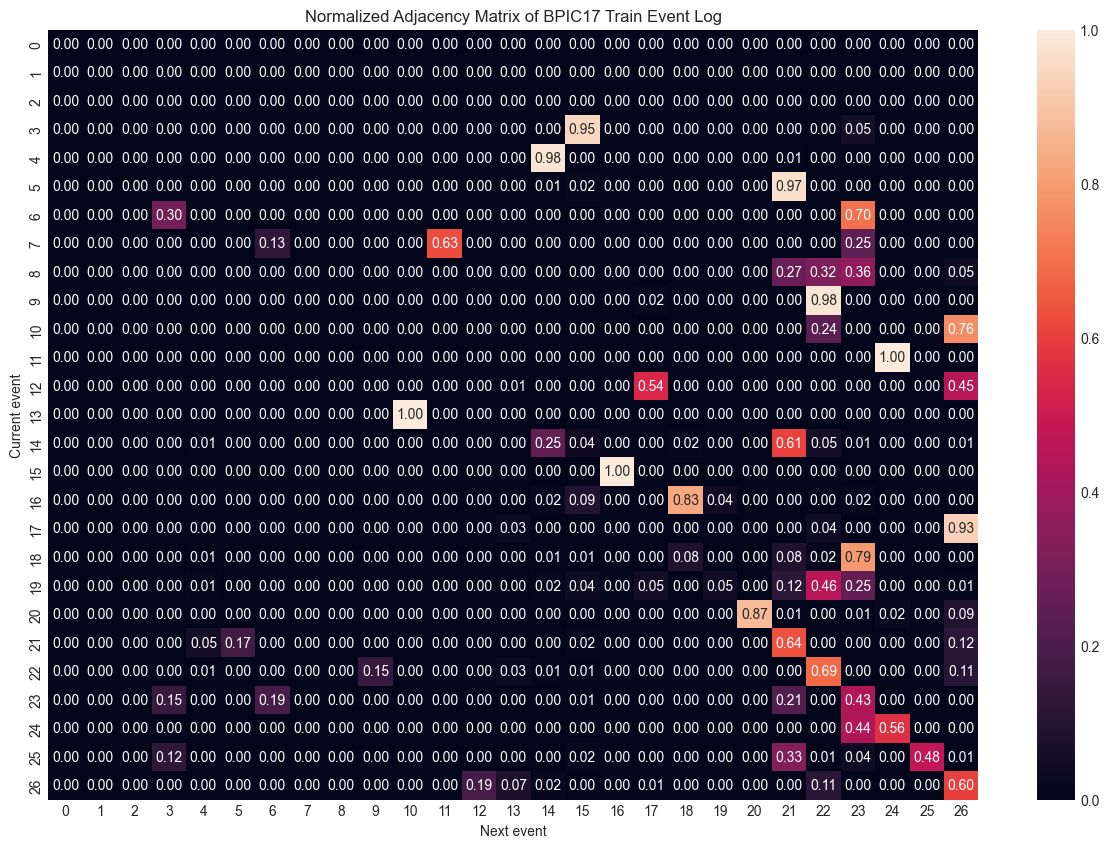

In [13]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(15, 10))
ax = sns.heatmap(transition_matrix, annot=True, fmt=".2f", )
ax.set_title('Normalized Adjacency Matrix of BPIC17 Train Event Log')
ax.set_xlabel('Next event')
ax.set_ylabel('Current event')
plt.show()

For each case, we aim to explain, segments should be calculated separately using PELT algorithm. Since the trace prefix considered is not long, we keep the step size of the algorithm and the minimum segment size equal to 1.

In [14]:
def grid_search_for_best_segmentation(trace, transition_matrix, penalty_params={'start':0, 'stop': 1, 'step': 0.01}):
    optimizer = rpt.Pelt(custom_cost=TransitionCost(transition_matrix), jump=1, min_size=1)
    optimizer.fit(trace)
    
    penalties = np.arange(penalty_params['start'], penalty_params['stop'], penalty_params['step'])
    results = [optimizer._seg(penalty) for penalty in penalties]
    cost_list  =  [sum(result.values()) for result in results]
    seg_num_list = [len(result) for result in results]

    best_aic = 1e10 
    best_penalty  =  0

    for i, (cost, segments_num) in enumerate(zip(cost_list, seg_num_list)):
        aic = 2 * segments_num - 2 * np.log(cost)
        if aic < best_aic:
            best_aic = aic
            best_penalty  = penalties[i]

    breakpoints = optimizer.fit(trace).predict(pen=best_penalty)

    return breakpoints

PELT algorithm is highly dependend on the defined penalty. Thus, we run a grid search for each trace for the optimal penalty value calculation. The default range of values for the penaalty argument is the range from 0 to 1 with the step 0.01.

In [15]:
palette = sns.color_palette(cc.glasbey_category10, n_colors=30)
activity_lookup = test_loader.dataset.log.itos['activity']
output_dir = r'D:\PycharmProjects\xAI-PPM\output\segmentation\bpi17'
tp_segments = []

for i, tp_case in enumerate(tp_explicands):
    tp_trace = tp_case[0, :, 0]
    breakpoints = grid_search_for_best_segmentation(tp_trace, transition_matrix)

    trace_segments = []
    trace_seg_ids = []
    for j, t in enumerate(tp_trace):
        if j == 0 or j in breakpoints:
            trace_segments.append([t])
            trace_seg_ids.append([j])
        else:
            trace_segments[-1].append(t)
            trace_seg_ids[-1].append(j)
    tp_segments.append({'segments': trace_segments, 'segment_ids':  trace_seg_ids}) 

    seg_boundaries = {}
    for c, seg in enumerate(trace_seg_ids):
        seg_boundaries[(seg[0], seg[-1])] = palette[c]

    figure = plot_trace_vertical(tp_trace, figsize=(3, 7),
                            seg_boundaries_colors=seg_boundaries, 
                            activity_lookup=activity_lookup, 
                            title=f'y_pred = {round(tp_predictions[i], 3)} | y_true = 1')
    figure.savefig(osp.join(output_dir, f'tp_case_{i}.png'), dpi=300, 
                   facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.close()

In [16]:
fp_segments = []

for i, fp_case in enumerate(fp_explicands):
    fp_trace = fp_case[0, :, 0]
    breakpoints = grid_search_for_best_segmentation(fp_trace, transition_matrix)

    trace_segments = []
    trace_seg_ids = []
    for j, t in enumerate(fp_trace):
        if j == 0 or j in breakpoints:
            trace_segments.append([t])
            trace_seg_ids.append([j])
        else:
            trace_segments[-1].append(t)
            trace_seg_ids[-1].append(j)
    fp_segments.append({'segments': trace_segments, 'segment_ids':  trace_seg_ids}) 

    seg_boundaries = {}
    for c, seg in enumerate(trace_seg_ids):
        seg_boundaries[(seg[0], seg[-1])] = palette[c]

    figure = plot_trace_vertical(fp_trace, figsize=(3, 7),
                                 seg_boundaries_colors=seg_boundaries, 
                                 activity_lookup=activity_lookup, 
                                 title=f'y_pred = {round(fp_predictions[i], 3)} | y_true = 0')
    figure.savefig(osp.join(output_dir, f'fp_case_{i}.png'), dpi=300, 
                   facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.close()

In [17]:
tn_segments = []

for i, tn_case in enumerate(tn_explicands):
    tn_trace = tn_case[0, :, 0]
    breakpoints = grid_search_for_best_segmentation(tn_trace, transition_matrix)

    trace_segments = []
    trace_seg_ids = []
    for j, t in enumerate(tn_trace):
        if j == 0 or j in breakpoints:
            trace_segments.append([t])
            trace_seg_ids.append([j])
        else:
            trace_segments[-1].append(t)
            trace_seg_ids[-1].append(j)
    tn_segments.append({'segments': trace_segments, 'segment_ids':  trace_seg_ids}) 

    seg_boundaries = {}
    for c, seg in enumerate(trace_seg_ids):
        seg_boundaries[(seg[0], seg[-1])] = palette[c]

    figure = plot_trace_vertical(tn_trace, figsize=(3, 7),
                                 seg_boundaries_colors=seg_boundaries, 
                                 activity_lookup=activity_lookup, 
                                 title=f'y_pred = {round(tn_predictions[i], 3)} | y_true = 0')
    figure.savefig(osp.join(output_dir, f'tn_case_{i}.png'), dpi=300, 
                   facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.close()

## 2. Calculate SeqSHAP values 

At this step, we calculate SHAP values for each segment to explain its importance to the model outcome.

In [18]:
import shap
from typing import List
from shap import Explanation
from shap.utils._legacy import LogitLink, IdentityLink


from local_xai.seqshap.seqshap_kernel import SeqShapKernel
from local_xai.seqshap.plots import plot_segment_shap_heatmap
from timeshap.utils import calc_avg_event, calc_avg_sequence
from timeshap.wrappers.outcome_predictor_wrapper import OutcomePredictorWrapper 

plt.style.use('seaborn-v0_8-white') 

In [19]:
wrapped_model = OutcomePredictorWrapper(model, batch_budget=1, categorical_indices=[0], 
                                         target='next_activity', device=torch.device('cpu'))

fetching_f = lambda x, hs=None: wrapped_model(sequences=x, hidden_state=hs)

### 2.1 Define a baseline case

The trivial approach, which is reffered to as marginal SHAP, takes an average of numerical features and a mode of categorical features in the randomly sampled cases from the train  event log. 

In [20]:
bc_data_ind = np.random.randint(0, 1000, size=100).tolist() 

bc_data = [ ]
for ind in bc_data_ind:
    bc_trace = train_loader.dataset[ind]
    bc_trace_arr = np.concatenate([bc_trace[0].numpy(), bc_trace[1].numpy()], axis=-1)
    bc_trace_arr = np.expand_dims(bc_trace_arr, axis=0)
    bc_data.append(bc_trace_arr)
    
lengths = list(map(lambda x: x[0].shape[0], bc_data))
# Keep only short traces (length <= 30) for average event calculation
short_traces = [trace for trace in bc_data if trace.shape[1]<= 30]

max_length = max([trace.shape[1] for trace in short_traces])

bc_data_padded = [np.pad(trace, mode='constant', pad_width=((0, 0), (0, max_length-trace.shape[1]), (0, 0))) for trace in short_traces]
bc_padded_array = np.concatenate(bc_data_padded, axis=0)
print('Padded background data shape for the calculation of an average event: ', bc_padded_array.shape)

Padded background data shape for the calculation of an average event:  (39, 29, 11)


In [21]:
cat_features_ind: List[str|int] = [0]
num_features_ind: List[str|int] = [i+1 for i, _ in enumerate(config['continuous_features'])]
all_feature_names = list(config['categorical_features']) + list(config['continuous_features'])

avg_sequence = calc_avg_sequence(data=bc_padded_array, 
                                 categorical_feats=cat_features_ind, 
                                 numerical_feats=num_features_ind,
                                 model_features=all_feature_names)

avg_event = calc_avg_event(data=avg_sequence[np.where(avg_sequence[:, 0]!=0)],  # calculating average event only for rows with non-zero activities
                           categorical_feats=cat_features_ind,
                           numerical_feats=num_features_ind,
                           model_features=all_feature_names)

In [22]:
[trace.shape for trace in tp_explicands]

[(1, 15, 11), (1, 15, 11), (1, 15, 11), (1, 15, 11), (1, 15, 11)]

In [23]:
print("Model score for the explicand {:.5f}".format(fetching_f(tp_explicands[0])[0].item()))
print("Model score on the avg event: {:.5f}".format(fetching_f(np.expand_dims(avg_event, axis=0))[0].item()))

Model score for the explicand 0.54469
Model score on the avg event: 0.40697


### 2.2 Calculate SeqSHAP values

In [24]:
sv_result_output_dir = r'D:\PycharmProjects\xAI-PPM\output\shap_values\bpi17'

Explanations for the group of cases that was correctly predicted as "O_Cancelled" 

In [25]:
shap.initjs()

tp_cases_explainers = []
for i, (tp_case, tp_segments_item) in enumerate(zip(tp_explicands, tp_segments)):
    _, tp_seg_ids  = tp_segments_item['segments'], tp_segments_item['segment_ids']
    # seg_explainer = SeqShapKernel(fetching_f, avg_event, rs=52, mode="segment", 
    #                               segment_ids=tp_seg_ids, link=IdentityLink())
    seg_explainer = SeqShapKernel(fetching_f, avg_event, rs=52, mode="segment", 
                                  segment_ids=tp_seg_ids, link=IdentityLink())
    segment_level_sv = seg_explainer.shap_values(tp_case)
    # Plot sv in the force plot
    segment_names = getattr(seg_explainer.data, "group_names")
    segment_level_expl = Explanation(segment_level_sv, base_values=seg_explainer.expected_value,
                          feature_names=segment_names)
    force_plot = shap.plots.force(segment_level_expl, matplotlib=True, contribution_threshold=0, show=False)
    force_plot.savefig(osp.join(sv_result_output_dir, f'tp_case_{i}_seg_sv_force.png'), 
                       dpi=300, facecolor='white', edgecolor='white', bbox_inches='tight')

    # Plot the heatmap of segments  sv
    heatmap = plot_segment_shap_heatmap(segment_names, segment_level_sv)
    heatmap.savefig(osp.join(sv_result_output_dir, f'tp_case_{i}_seg_sv_heatmap.png'), 
                    dpi=300, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.close()

    feature_explainer = SeqShapKernel(fetching_f, avg_event, rs=52, mode="feature")
    feature_level_sv = feature_explainer.shap_values(tp_case)

    # Plot sv for each feature of a given case
    fig = plt.figure()
    feature_level_expl = Explanation(feature_level_sv, base_values=feature_explainer.expected_value,
                                    feature_names=config['categorical_features']+config['continuous_features'])
    ax = shap.plots.bar(feature_level_expl, show=False)
    plt.tight_layout()
    plt.savefig(osp.join(sv_result_output_dir, f'tp_case_{i}_feat_sv_bar.png'), 
                       dpi=300, facecolor='white', edgecolor='white')

    tp_cases_explainers.append({'segment_explainer': seg_explainer,
                                'feature_explainer': feature_explainer})

Explanations for the group of cases that was misclassified as "O_Cancelled", although the true outcome is "O_Accepted" 

In [26]:
shap.initjs()

fp_cases_explainers = []
for i, (fp_case, fp_segments_item) in enumerate(zip(fp_explicands, fp_segments)):
    _, fp_seg_ids  = fp_segments_item['segments'], fp_segments_item['segment_ids']
    seg_explainer = SeqShapKernel(fetching_f, avg_event, rs=52, mode="segment",
                                  segment_ids=fp_seg_ids, link=IdentityLink())
    segment_level_sv = seg_explainer.shap_values(fp_case)
    # Plot sv in the force plot
    segment_names = getattr(seg_explainer.data, "group_names")
    segment_level_expl = Explanation(segment_level_sv, base_values=seg_explainer.expected_value,
                          feature_names=segment_names)
    force_plot = shap.plots.force(segment_level_expl, matplotlib=True, contribution_threshold=0, show=False)
    force_plot.savefig(osp.join(sv_result_output_dir, f'fp_case_{i}_seg_sv_force.png'), 
                       dpi=300, facecolor='white', edgecolor='white', bbox_inches='tight')

    # Plot the heatmap of segments  sv
    heatmap = plot_segment_shap_heatmap(segment_names, segment_level_sv)
    heatmap.savefig(osp.join(sv_result_output_dir, f'fp_case_{i}_seg_sv_heatmap.png'), 
                    dpi=300, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.close()

    feature_explainer = SeqShapKernel(fetching_f, avg_event, rs=52, mode="feature")
    feature_level_sv = feature_explainer.shap_values(fp_case)

    # Plot sv for each feature of a given case
    fig = plt.figure()
    feature_level_expl = Explanation(feature_level_sv, base_values=feature_explainer.expected_value,
                                    feature_names=config['categorical_features']+config['continuous_features'])
    ax = shap.plots.bar(feature_level_expl, show=False)
    plt.tight_layout()
    plt.savefig(osp.join(sv_result_output_dir, f'fp_case_{i}_feat_sv_bar.png'), 
                       dpi=300, facecolor='white', edgecolor='white')

    fp_cases_explainers.append({'segment_explainer': seg_explainer,
                                'feature_explainer': feature_explainer})

In [27]:
shap.initjs()

tn_cases_explainers = []
for i, (tn_case, tn_segments_item) in enumerate(zip(tn_explicands, tn_segments)):
    _, tn_seg_ids  = tn_segments_item['segments'], tn_segments_item['segment_ids']
    seg_explainer = SeqShapKernel(fetching_f, avg_event, rs=52, mode="segment", 
                                  segment_ids=tn_seg_ids, link=IdentityLink())
    segment_level_sv = seg_explainer.shap_values(tn_case)
    # Plot sv in the force plot
    segment_names = getattr(seg_explainer.data, "group_names")
    segment_level_expl = Explanation(segment_level_sv, base_values=seg_explainer.expected_value,
                          feature_names=segment_names)
    force_plot = shap.plots.force(segment_level_expl, matplotlib=True, contribution_threshold=0, show=False)
    force_plot.savefig(osp.join(sv_result_output_dir, f'tn_case_{i}_seg_sv_force.png'), 
                       dpi=300, facecolor='white', edgecolor='white', bbox_inches='tight')

    # Plot the heatmap of segments  sv
    heatmap = plot_segment_shap_heatmap(segment_names, segment_level_sv)
    heatmap.savefig(osp.join(sv_result_output_dir, f'tn_case_{i}_seg_sv_heatmap.png'), 
                    dpi=300, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.close()

    feature_explainer = SeqShapKernel(fetching_f, avg_event, rs=52, mode="feature")
    feature_level_sv = feature_explainer.shap_values(tn_case)

    # Plot sv for each feature of a given case
    fig = plt.figure()
    feature_level_expl = Explanation(feature_level_sv, base_values=feature_explainer.expected_value,
                                    feature_names=config['categorical_features']+config['continuous_features'])
    ax = shap.plots.bar(feature_level_expl, show=False)
    plt.tight_layout()
    plt.savefig(osp.join(sv_result_output_dir, f'tn_case_{i}_feat_sv_bar.png'), 
                       dpi=300, facecolor='white', edgecolor='white')

    tn_cases_explainers.append({'segment_explainer': seg_explainer,
                                'feature_explainer': feature_explainer})

c:\Users\sahat\anaconda3\envs\conda_env\Lib\site-packages\shap\plots\_force_matplotlib.py:350: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


# 3. Estimate sensitivity of SHAPvalue estimates

### 3.1 Identify anomalous cases in coalitions

In [ ]:
# from utils.unsup_anomaly_detection.gama.model import GAMA

In [72]:
def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [ ]:
log_df = train_loader.dataset.log.dataframe
n_cols = n_rows = len(train_loader.dataset.log.itos['activity'])
adjacency = np.zeros((n_rows, n_cols), dtype=int)

for case_id, group in log_df.groupby('case_id'):
    activities = group['activity'].values
    for i in range(len(activities) - 1):
        adjacency[activities[i], activities[i + 1]] += 1

In [ ]:
traces = [] # by traces we mean activity labels belonging to a case
trace_lens =  []
for batch in train_loader:
    x_cat, _, _, _ = batch
    traces.append(x_cat[0, :, 0])
    trace_lens .append(x_cat.shape[1])

padded_acivities = torch.nn.utils.rnn.pad_sequence(traces, batch_first=True, padding_value=0.0)

In [125]:
def graph_generator(adjacency_matrix, padded_acivities, trace_lens: List[int], beta: float = 0.005):

    num_cases = len(trace_lens)
    adjacency_matrix =  np.array(adjacency_matrix >=  beta* num_cases, dtype='int32')
    onehot_encoded = to_categorical(padded_acivities)
    node_xs = []
    edge_indeces = []

    for case_index in range(num_cases):
        edge = []
        xs = torch.tensor(onehot_encoded[case_index, :, ])

        if  trace_lens[case_index] > 1:
            node = padded_acivities[case_index, : trace_lens[case_index]]
            for activity_index in range(0,  trace_lens[case_index]):
                out = np.argwhere(adjacency_matrix[padded_acivities[case_index, activity_index]] == 1).flatten()
                a = set(node)
                b = set(out)
                if activity_index + 1 < trace_lens[case_index]:
                    edge.append([activity_index, activity_index+1])
                for node_name in a.intersection(b):
                    for node_index in np.argwhere(node == node_name).flatten():
                        if  activity_index + 1 != node_index:
                            edge.append([activity_index, node_index.item()])

        edge_index = torch.tensor(edge, dtype=torch.long)
        node_xs.append(xs)
        edge_indeces.append(edge_index.T)
    
    return node_xs, edge_indeces
    
    

In [107]:
activity_nodes, activity_edges = graph_generator(adjacency, padded_acivities, trace_lens)

In [131]:
import numpy as np
import torch
from torch import nn
from torch_geometric.data import Data, Batch
from tqdm import tqdm
import random
from utils.unsup_anomaly_detection.gama.gat_ae import GAT_AE


class GAMA():
    def __init__(self, seed=None ,n_epochs=20 ,batch_size= 64, lr=0.0005 ,b1=0.5 ,b2=0.999 ,
                 hidden_dim = 64, GAT_heads = 4, decoder_num_layers = 2,TF_styles:str='FAP'):
        if TF_styles not in ['AN', 'PAV', 'FAP']:
            raise Exception('"TF_styles" must be a value in ["AN","PAV", "FAP"]')

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.seed = seed
        self.n_epochs = n_epochs
        self.lr =lr
        self.b1 =b1
        self.b2 =b2
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.GAT_heads = GAT_heads
        self.decoder_num_layers = decoder_num_layers
        self.TF_styles = TF_styles
        self.name = 'GAMA'
        if type(self.seed) is int:
            torch.manual_seed(self.seed)

    def setup_data(self, 
                   activities: np.ndarray,
                   adjacency_matrix: np.ndarray, 
                   attribute_dims: List[int], 
                   trace_lens: List[int],
                   beta: float):
        self.activities = activities
        self.attribute_dims = attribute_dims
        self.trace_lens = trace_lens
        self.max_len = max(trace_lens)
        self.num_cases= len(trace_lens)
        self.beta = beta
    
        self.mask = np.ones(activities.shape, dtype=bool)
        for m, j in zip(self.mask, self.trace_lens):
            m[:j] = False

        self.nodes_xs, self.edge_indexs = graph_generator(adjacency_matrix, activities, self.trace_lens, self.beta)

    def fit(self):
        """
        Trains multigraph encoder and decoder on the provided dataset
        Args:
            attribute_dims (int): 
            max_len (int): length of a case with the maximum number of events
        """
        self.model = GAT_AE(self.attribute_dims, self.max_len, self.hidden_dim, self.GAT_heads, 
                            self.decoder_num_layers, self.TF_styles)
        loss_func = nn.CrossEntropyLoss()
        self.model.to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer=optimizer,
            gamma=0.85
        )
        Xs = torch.LongTensor(self.activities)

        print("*" * 10 + "training" + "*" * 10)
        for epoch in range(int(self.n_epochs)):
            train_loss = 0.0
            train_num = 0
            # Custom dataloader
            indexes = [i for i in range(self.num_cases)]
            random.shuffle(indexes)
            for bathc_i in tqdm(range(self.batch_size, len(indexes)+1, self.batch_size)):
                this_batch_indexes = indexes[bathc_i - self.batch_size:bathc_i]
                nodes_list = [self.nodes_xs[i] for i in this_batch_indexes]
                edge_indexs_list = [self.edge_indexs[i] for i in this_batch_indexes]
                Xs_list = [Xs[this_batch_indexes].to(self.device)]
                graph_batch = Batch.from_data_list([Data(x=nodes_list[b], edge_index=edge_indexs_list[b])
                                                    for b in range(len(nodes_list))])
                graph_batch_list = [graph_batch.to(self.device)]
                mask = torch.tensor(self.mask[this_batch_indexes]).to(self.device)

                attr_reconstruction_outputs = self.model(graph_batch_list, Xs_list, mask, len(this_batch_indexes))
                optimizer.zero_grad()

                loss = 0.0
                mask[:, 0] = True 
                for i in range(len(self.attribute_dims)):
                    # --------------
                    # Apart from the starting character of each attribute, other reconstruction errors
                    # ---------------
                    pred = attr_reconstruction_outputs[i][~mask]
                    true = Xs_list[i][~mask]
                    loss += loss_func(pred, true)

                train_loss += loss.item()/len(self.attribute_dims)
                train_num += 1
                loss.backward()
                optimizer.step()
            ## Calculate the loss and accuracy of one epoch on the training set.
            train_loss_epoch = train_loss / train_num
            print(f"[Epoch {epoch + 1:{len(str(self.n_epochs))}}/{self.n_epochs}] "
                  f"[loss: {train_loss_epoch:3f}]")
            scheduler.step()

        return self

    def detect(self, ):
        self.model.eval()

        with torch.no_grad():
            final_res = []
            # attribute_dims = 

            Xs = []
            for i, _ in enumerate(self.attribute_dims):
                Xs.append(torch.LongTensor(self.activities))

            print("*" * 10 + "detecting" + "*" * 10)

            pre = 0

            # TODO: len(dataset)
            for bathc_i in tqdm(range(self.batch_size, self.num_cases + self.batch_size, self.batch_size)):
                if bathc_i <= self.num_cases:
                    this_batch_indexes = list(range(pre, bathc_i))
                else:
                    this_batch_indexes = list(range(pre, self.num_cases))

                nodes_list = [self.nodes_xs[i] for i in this_batch_indexes]
                edge_indexs_list = [self.edge_indexs[i] for i in this_batch_indexes]
                Xs_list = []
                graph_batch_list = []
                for i in range(len(self.attribute_dims)):
                    Xs_list.append(Xs[i][this_batch_indexes].to(self.device))
                    graph_batch = Batch.from_data_list([Data(x=nodes_list[b][i], edge_index=edge_indexs_list[b])
                                                        for b in range(len(nodes_list))])
                    graph_batch_list.append(graph_batch.to(self.device))
                mask = torch.tensor(self.mask[this_batch_indexes]).to(self.device)

                attr_reconstruction_outputs =   self.model(graph_batch_list, Xs_list, mask, len(this_batch_indexes))

                for attr_index in range(len(self.attribute_dims)):
                    attr_reconstruction_outputs[attr_index] = torch.softmax(attr_reconstruction_outputs[attr_index],
                                                                            dim=2)

                this_res = []
                for attr_index in range(len(self.attribute_dims)):
                    # The sum of probabilities of taking the attribute value that is larger than the actual attribute value.
                    temp = attr_reconstruction_outputs[attr_index]
                    index = Xs_list[attr_index].unsqueeze(2)
                    probs = temp.gather(2, index)
                    temp[(temp <= probs)] = 0
                    res = temp.sum(2)
                    res = res * (~mask)
                    this_res.append(res)

                final_res.append(torch.stack(this_res, 2))

                pre = bathc_i

            attr_level_abnormal_scores = np.array(torch.cat(final_res, 0).detach().cpu())
            trace_level_abnormal_scores = attr_level_abnormal_scores.max((1, 2))
            event_level_abnormal_scores = attr_level_abnormal_scores.max((2))
            return trace_level_abnormal_scores, event_level_abnormal_scores, attr_level_abnormal_scores



In [132]:
ad_model = GAMA()
ad_model.setup_data(padded_acivities.numpy(),
                    adjacency_matrix=adjacency,
                    attribute_dims=[27],
                    trace_lens=trace_lens,
                    beta=0.005)

In [134]:
ad_model.fit()

**********training**********


100%|██████████| 293/293 [36:21<00:00,  7.44s/it] 


[Epoch  1/20] [loss: 0.912501]


  1%|          | 2/293 [00:09<23:16,  4.80s/it]


KeyboardInterrupt: 